In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, use the LeNet CNN model
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

Necessities imported!


In [2]:
#This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")


current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True

if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)

os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)


lmdb train db found!
lmdb test db found!
Looks like you ran this before, so we need to cleanup those old files...
training data folder:/home/rohit/caffe2_notebooks/tutorial_data/mnist
workspace root folder:/home/rohit/caffe2_notebooks/tutorial_files/tutorial_mnist


In [3]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    #data_uint8, label = brew.db_input(
    #    model,
    #    blobs_out=["data_uint8", "label"],
    #    batch_size=batch_size,
    #    db=db,
    #    db_type=db_type,
    #)
    ### load the data from db - Method 2 using TensorProtosDB
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    #output_blob, old_shape = model.Reshape(['data'], ['output_blob', 'old_shape'], shape=(newshape_N,C,H,W))
    # cast the data to float
    data_shape = model.Shape(data_uint8)
    data_reshape,old_shape = model.Reshape(data_uint8,['data_reshape','old_shape'],shape=(64,1,32,32))
    data = model.Cast(data_reshape, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [4]:
def AddModel(model,data):
    conv1 = brew.conv(model,data,"conv1",dim_in = 1,dim_out = 40,kernel = 3)
    relu1 = brew.relu(model,conv1,"relu1");
    maxpool1 = brew.max_pool(model,relu1,"max_pool1",kernel=2,stride=2)
    
    conv2 = brew.conv(model,maxpool1,"conv2",dim_in =40 ,dim_out = 100,kernel = 3)
    relu2 = brew.relu(model,conv2,"relu2");
    maxpool2 = brew.max_pool(model,relu2,"max_pool2",kernel=2,stride=2)
    
    conv3 = brew.conv(model,maxpool2,"conv3",dim_in =100 ,dim_out = 500,kernel = 3)
    relu3 = brew.relu(model,conv3,"relu3");
    maxpool3 = brew.max_pool(model,relu3,"max_pool3",kernel=2,stride=2)
    
    fc3 = brew.fc(model, maxpool3, 'fc3', dim_in=500 * 1 * 1, dim_out=1000)
    relu4 = brew.relu(model, fc3, 'relu4')
    
    pred = brew.fc(model, relu4, 'pred', dim_in=1000, dim_out=10)
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax
    
    

In [5]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [6]:
def AddTrainingOperator(model,softmax,label):
    xent = model.LabelCrossEntropy([softmax,label],"xent")
    loss = model.AveragedLoss(xent,"loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_sgd(
        model,
        base_learning_rate = 0.1,
        policy = 'step',
        stepsize = 1,
        gamma =0.99
    )

In [7]:
arg_scope = {'order':'NCHW'}
trainModel = model_helper.ModelHelper(name="mnist_train",arg_scope = arg_scope)
data,label = AddInput(trainModel,batch_size = 64,db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),db_type='lmdb')
softmax = AddModel(trainModel,data)
AddTrainingOperator(trainModel,softmax,label)

In [8]:
workspace.RunNetOnce(trainModel.param_init_net)
workspace.CreateNet(trainModel.net,overwrite=True)

numOfIter = 500
accuracy = np.zeros(numOfIter)
loss = np.zeros(numOfIter)

for i in range(numOfIter):
    workspace.RunNet(trainModel.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    data = workspace.blobs['data']
    print(data[0][0].shape)
    if i%25 == 0:
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

        
        
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

RuntimeError: [enforce fail at db.h:190] db_. Cannot open db: /home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb of type lmdb Error from operator: 
output: "dbreader_/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb" name: "" type: "CreateDB" arg { name: "db" s: "/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb" } arg { name: "db_type" s: "lmdb" }

RuntimeError: [enforce fail at pybind_state.cc:168] ws->HasBlob(name). Can't find blob: data 

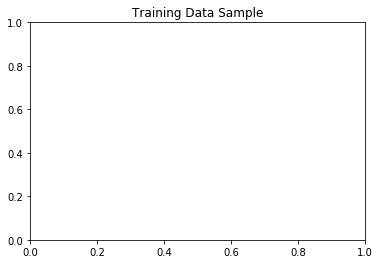

In [9]:
### Let's look at some of the training data
pyplot.figure()
pyplot.title("Training Data Sample")
# Grab the most recent data blob (i.e. batch) from the workspace
data = workspace.FetchBlob('data')
# Use visualize module to show the examples from the last batch that was fed to the model
_ = visualize.NCHW.ShowMultiple(data)

### Let's visualize the softmax result
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')
# Grab and visualize the softmax blob for the batch we just visualized. Since batch size
#  is 64, the softmax blob contains 64 vectors, one for each image in the batch. To grab
#  the vector for the first image, we can simply index the fetched softmax blob at zero.
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[1], 'ro')

In [ ]:
    pyplot.figure()
    pyplot.title("Conv1 Output Feature Maps for Most Recent Mini-batch")
    # Grab the output feature maps of conv1. Change this to conv2 in order to look into the second one.
    #  Remember, early convolutional layers tend to learn human-interpretable features but later conv
    #  layers work with highly-abstract representations. For this reason, it may be harder to understand
    #  features of the later conv layers.
    conv = workspace.FetchBlob('conv2')
    
    # We can look into any channel. Think of it as a feature model learned.
    # In this case we look into the 5th channel. Play with other channels to see other features
    conv = conv[:,[7],:,:]

    _ = visualize.NCHW.ShowMultiple(conv)